# Data Exploration for a Machine Learning Stock Predictor

In [1]:
# import needed libraries
import os
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
%matplotlib inline

## Helper functions
---

Global functions intended to make computations and exploration easier.

In [42]:

################################################
# Data Gathering Helpers
################################################
def path_to_data(ticker, base_dir='data'):
    return os.path.join(base_dir, '{}.csv'.format(ticker))

#
# returns the full data set of a single stock for visualization.
#
def example_full_data(ticker, dates):
    df = pd.DataFrame(index=dates)
    df = pd.read_csv(
            path_to_data(ticker), 
            index_col='Date', 
            parse_dates=True, 
            na_values=['nan'])
    return df

#
# Takes a list of stock symbols and returns a new data set filtered down to
# the data as an index, the symbols as column names and the values of the columns
# that stocks adjusted closing price.
#
def fetch_data(ticker_list, dates):
    df = pd.DataFrame(index=dates)
    
    if 'SPY' not in ticker_list:
        ticker_list.insert(0, 'SPY')
        
    for ticker in range(0, len(ticker_list)):
        df_temp = pd.read_csv(
            path_to_data(ticker_list[ticker]), 
            usecols=['Date', 'Adj Close'], 
            index_col='Date', 
            parse_dates=True, 
            na_values=['nan'])
        df_temp = df_temp.rename(columns={'Adj Close' : ticker_list[ticker]})
        df = df.join(df_temp)
    
    df = df.dropna(subset=['SPY'])
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    return df

################################################
# STATS Helpers
################################################

#
# normalize the price of the data so each stock starts at zero
# in order to truly see how they are doing compared to the S&P 500
#
def normalize_data(df):
    return df/df.iloc[0,:]

#
# Print the stats of each stock
#
def print_stats(df):
    print 'Global Mean:'
    print df.mean()
    print '\nGlobal Median:'
    print df.median()
    print '\nGlobal Std:'
    print df.std()

#
# Calculate the daily returns of each stock
#
def get_daily_returns(df):
    daily_returns = df.copy()
    daily_returns[1:] = (daily_returns[1:] / daily_returns[0:-1].values) - 1
    daily_returns.iloc[0, : ] = 0
    return daily_returns

#
# Calculate the rolling mean of
# each stock. Window value can change to
# optimize the results
#
def get_rolling_mean(vals, window=20):
    return vals.rolling(window,center=False).mean()

#
# Calculate the rolling STD of
# each stock. Window value can change to
# optimize the results
#
def get_rolling_std(vals, window=20):
    return vals.rolling(window,center=False).std()

#
# Calculate the Bollinger Bands of each stock
# This will be one of the defining features
#
def get_bollinger_bands(rolling_mean, rolling_std):
    lower_band = rolling_mean - (rolling_std * 2)
    upper_band = rolling_mean + (rolling_std * 2)
    return lower_band, upper_band

#
# Calculate the Bollinger Bands Ratios
# This will be one of the defining features
#
def get_bollinger_ratios(series, sma, r_std, window=20):
    bb = series.copy()
    bb[window:] = (bb[window:] - sma[window:]) / (2 * r_std[window:])
    return bb[window:]

#
# Return the momentum of each stock.
# The goal is to visulaize when a stock is going up
# or going down
#
def get_momentum(df, window=20):
    momentum = df.copy()
    momentum[window:] = (momentum[window:] / momentum[0:-window].values) - 1
    return momentum[window:]

#
# Returns the SMA ratio
#
def get_sma_ratio(df, window=20):
    sma = df.copy()
    sma[window:] = (sma[window:] / sma[0:-window].mean()) - 1
    return sma[window:]

#
# normalize the features so they are all within the same range
#
def normalize_feature(series):
    return (series - series.mean())/series.std()

################################################
# Graph Plotting Helpers
################################################
def plot_hist_with_stats(df, bins=10, title=''):
    
    mean = df.mean()
    std = df.std()
    
    df.hist(bins=bins)
    plt.axvline(mean, color='w', linestyle='dashed', linewidth=2)
    plt.axvline(mean + std, color='r', linestyle='dashed', linewidth=2)
    plt.axvline(mean - std, color='r', linestyle='dashed', linewidth=2)
    plt.show()

def plot_hist_multi(df, bins=10, title=''):
    for stock in df:
        df[stock].hist(bins=bins, label=stock, alpha = 0.5)
    plt.legend(loc='best')
    plt.show()
    
def print_bollinger_bands(series, rolling_mean, lower_band, upper_band, label=''):
    val = ax = series.plot(title='', label='Prices', fontsize=10)
    rm = rolling_mean.plot(label='Rolling Mean', ax=ax)
    ub = upper_band.plot(label='Upper Band', ax=ax)
    lb = lower_band.plot(label='Lower Band', ax=ax)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='best')
    ax.set_xlabel('Dates')
    ax.set_ylabel('Adjusted Close')
    plt.rcParams['figure.figsize'] = (20.0, 15.0)
    plt.show()
    
def plot_momentum(series, rolling_mean, label=''):
    val = ax = series.plot(title='Momentum: ' + label, label='Prices', fontsize=10)
    rm = rolling_mean.plot(label='Rolling Mean', ax=ax)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='best')
    plt.show()
    
def plot_data(df, title='Stock Prices', xlabel='Date', ylabel='Price'):
    ax = df.plot(title=title, fontsize=10)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()
    
def plot_predictions(true_vals, pred_vals, x_label='Actual', y_label='CLF Predictions'):
    fig, ax = plt.subplots()
    ax.scatter(actual_vals, pred_vals)
    ax.plot([pred_vals.min(), pred_vals.max()], [pred_vals.min(), pred_vals.max()], 'k--', lw=4)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.show()

## Process Data for Selected Stocks
---

In [3]:
# use two years of dates for data exploration
dates = pd.date_range('2015-07-14', '2017-07-14')

# four stocks used for evaluation
# final implimentation will also use
# four stocks at max
tickers = ['NVDA', 'IBM', 'GOOG', 'AAPL']

# window size for rolling stats
metrics_window = 10

df_full_example = example_full_data('SPY', dates)
df_explore = fetch_data(tickers, dates)

print 'Exapmle of Full Data Set of SPY (Benchmark)'
print df_full_example.head(n=5)
print '\n\nTop of the data as it will be used, filtered down to adjusted price.'
print df_explore.head(n=5)

Exapmle of Full Data Set of SPY (Benchmark)
                  Open        High         Low      Close   Adj Close  \
Date                                                                    
2010-07-15  109.610001  110.059998  108.169998  95.017952  109.680000   
2010-07-16  109.089996  109.209999  106.449997  92.401672  106.660004   
2010-07-19  107.050003  107.629997  106.220001  92.947449  107.290001   
2010-07-20  105.870003  108.559998  105.820000  93.978371  108.480003   
2010-07-21  109.040001  109.070000  106.629997  92.756844  107.070000   

               Volume  
Date                   
2010-07-15  232337900  
2010-07-16  282693400  
2010-07-19  186709000  
2010-07-20  258162400  
2010-07-21  264527000  


Top of the data as it will be used, filtered down to adjusted price.
                   SPY       NVDA         IBM        GOOG        AAPL
2015-07-14  210.679993  19.889999  168.610001  561.099976  125.610001
2015-07-15  210.610001  19.750000  168.529999  560.219971  126.82

## Visualize the Data of the Selected Stocks
---
In this section we now viualize the data sets based on date and adjusted closing values.
The second graph is normalized in order to visualize the true volitility of each stock
agains the S&P 500

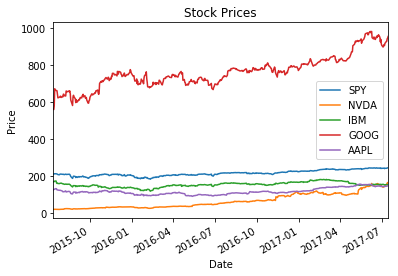

In [4]:
plot_data(df_explore)

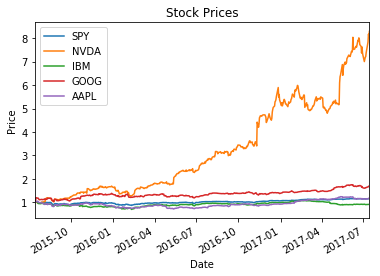

In [5]:
normalized_data = normalize_data(df_explore)
plot_data(normalized_data)

Based on the printed graphs we can see that NVDA is signigicanly more volitile over the two year period than the benchmark S&P 500 and the other stocks evaluated

## Global Stats
---

Global stats of the stocks we are interested in


In [17]:
print_stats(normalized_data)

Global Mean:
SPY     1.021891
NVDA    3.246513
IBM     0.910470
GOOG    1.357082
AAPL    0.927906
dtype: float64

Global Median:
SPY     1.008686
NVDA    2.654098
IBM     0.909703
GOOG    1.347870
AAPL    0.899809
dtype: float64

Global Std:
SPY     0.072933
NVDA    1.982375
IBM     0.078761
GOOG    0.154974
AAPL    0.134810
dtype: float64


## Rolling Stats
---
Visualization of the rolling stats

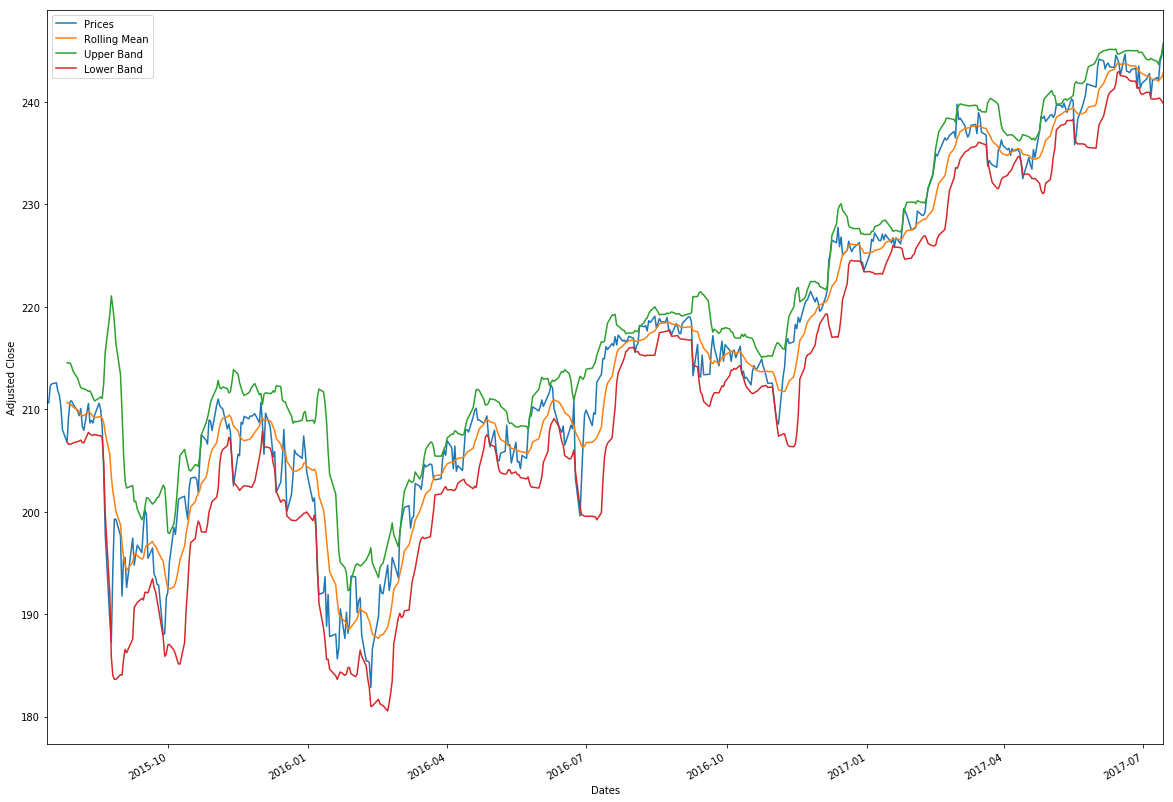

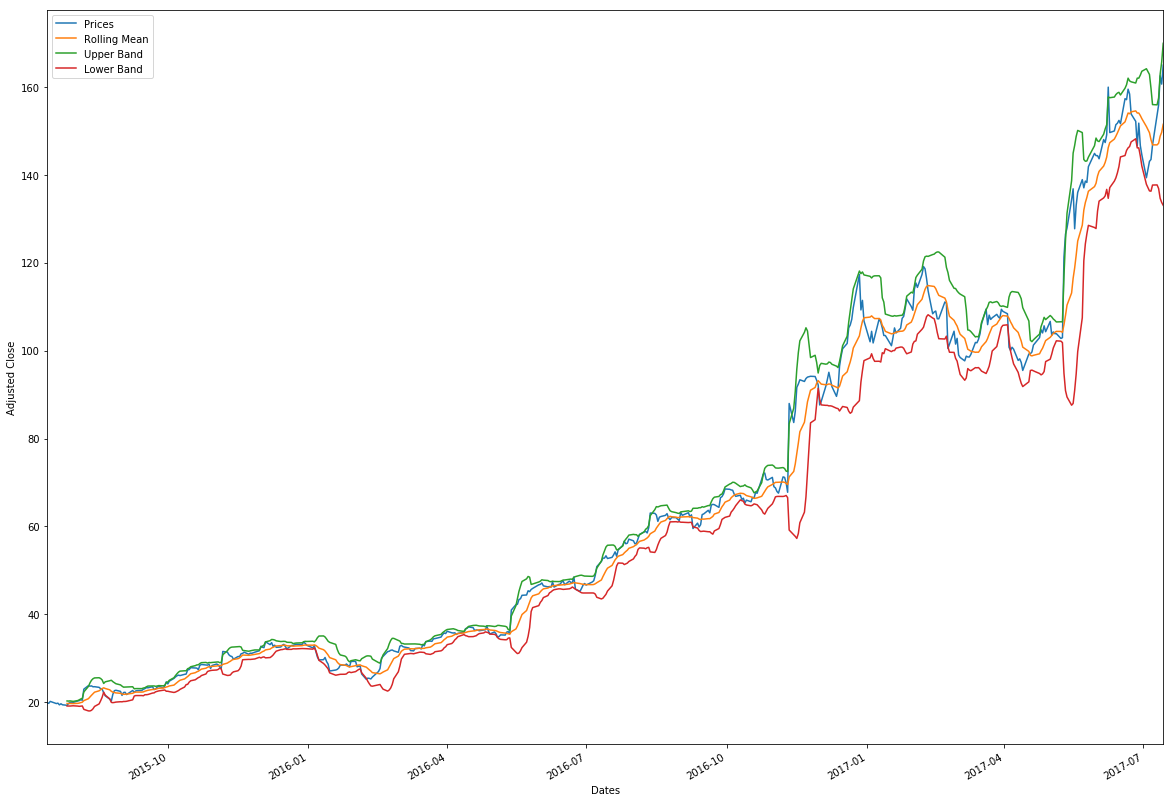

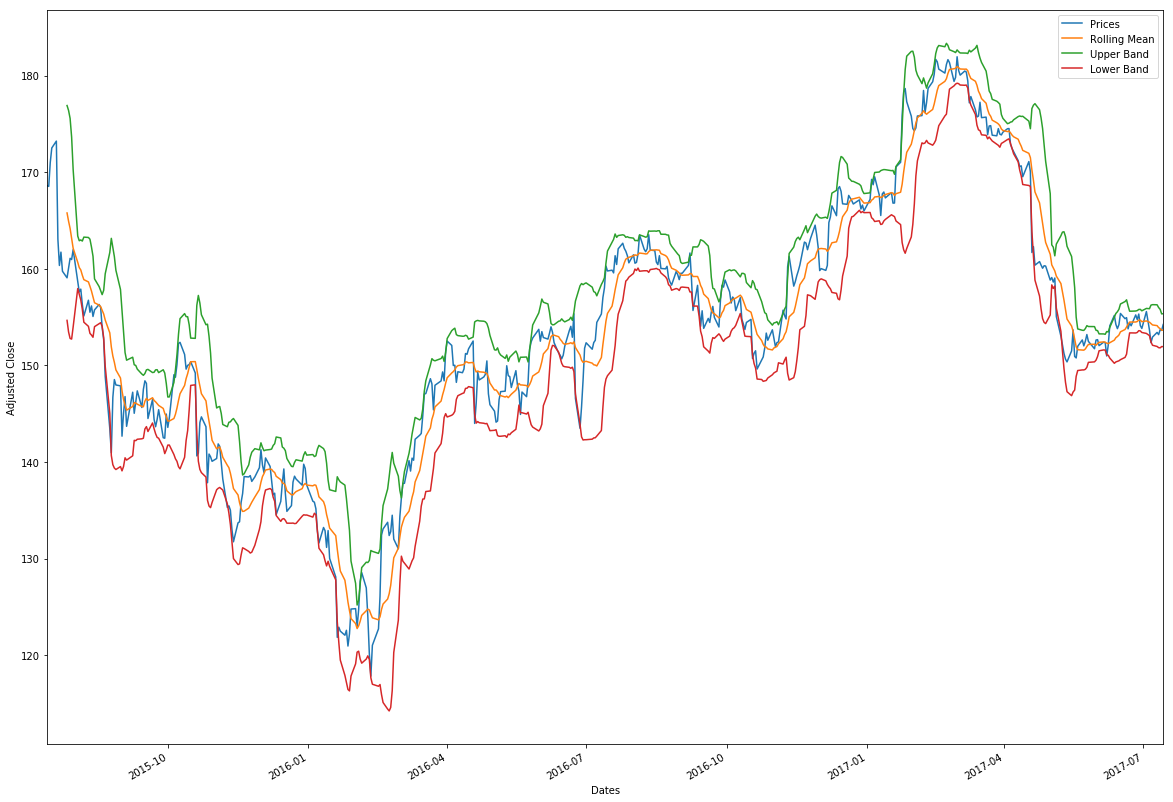

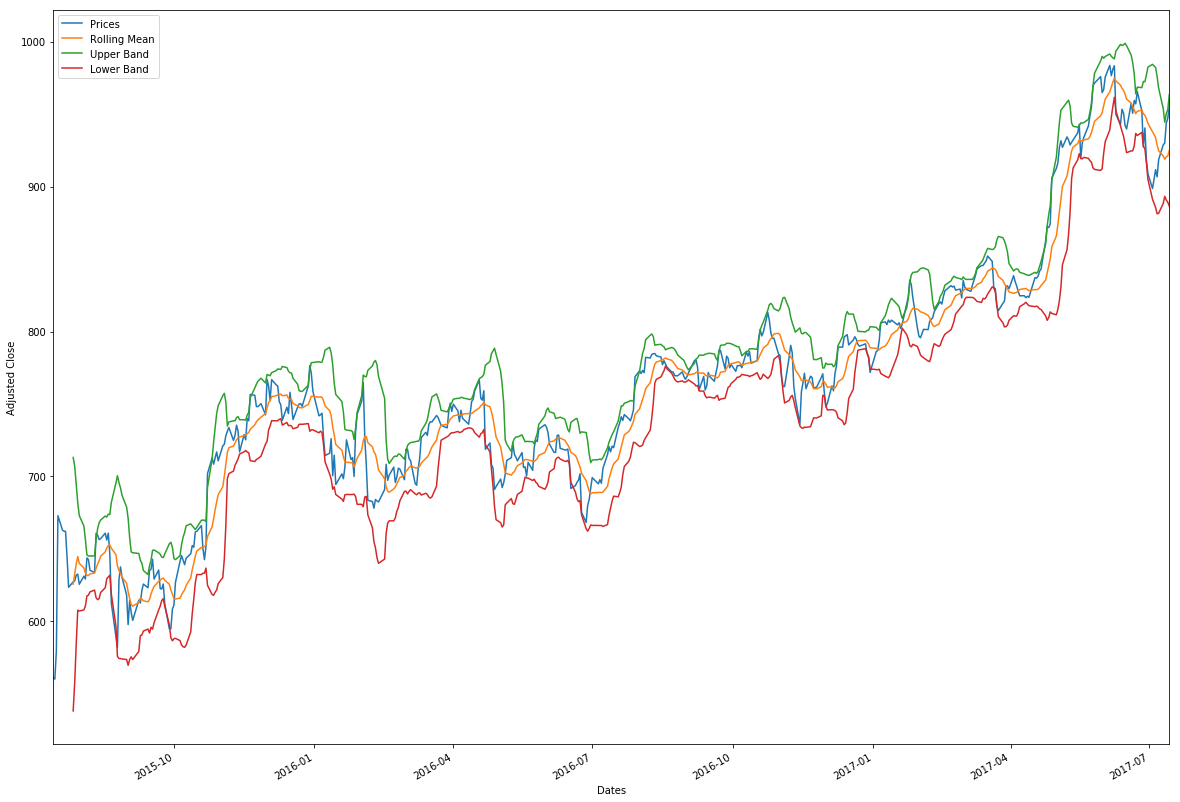

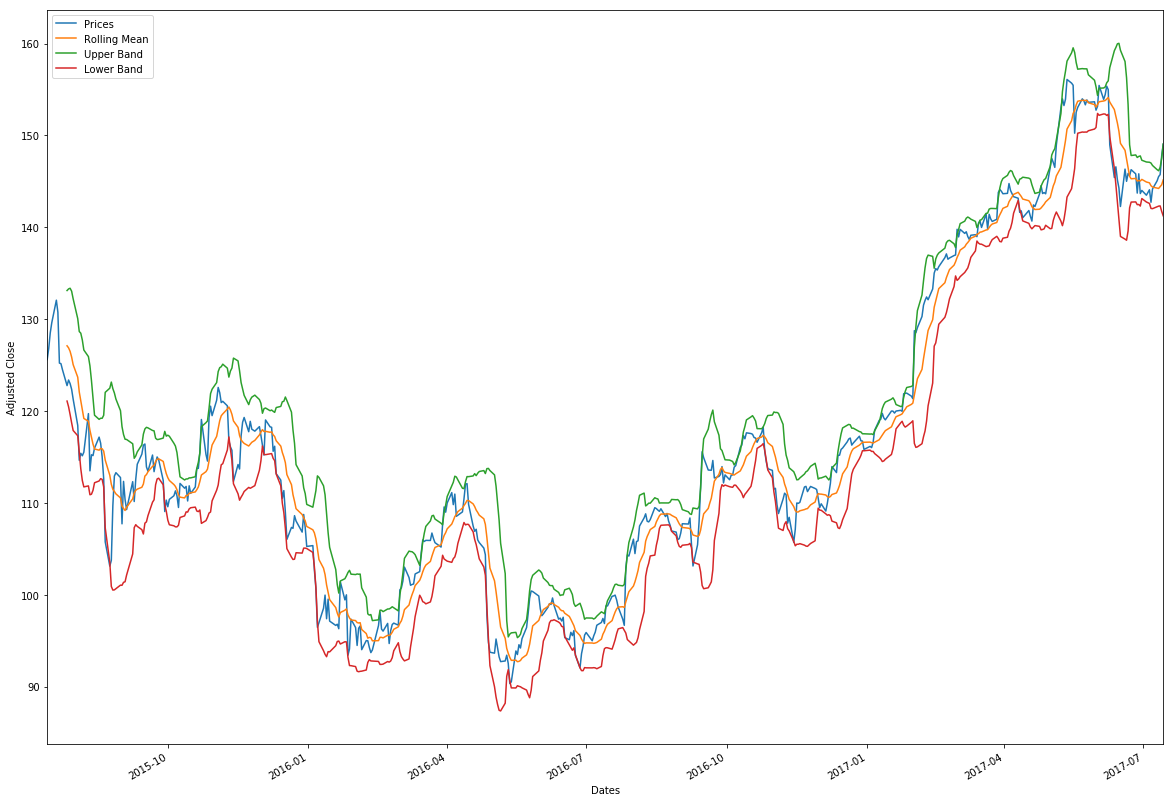

In [43]:
for symbol in tickers:
    rolling_mean = get_rolling_mean(df_explore[symbol], metrics_window)
    rolling_std = get_rolling_std(df_explore[symbol], metrics_window)
    lower_band, upper_band = get_bollinger_bands(rolling_mean, rolling_std)
    print_bollinger_bands(df_explore[symbol], rolling_mean, lower_band, upper_band, symbol)

## Daily Returns
---
Visualization of daily returns

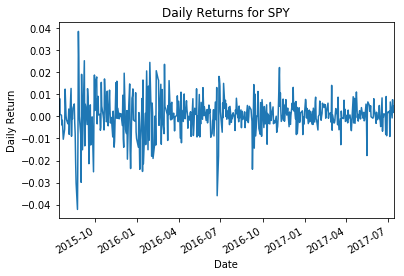

Max/Min Daily Returns for SPY
Max: 0.0383937782155
Min: -0.0421068691088





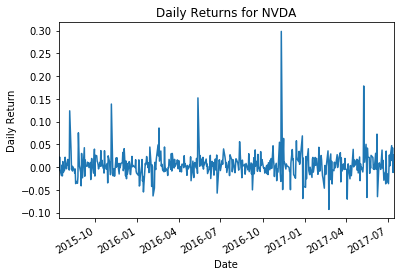

Max/Min Daily Returns for NVDA
Max: 0.298067063512
Min: -0.0927230391347





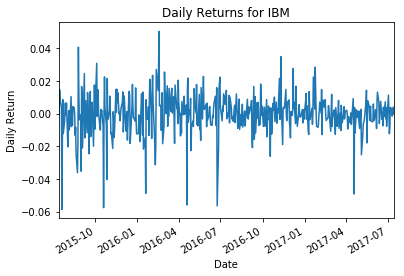

Max/Min Daily Returns for IBM
Max: 0.0503568525037
Min: -0.0585959701039





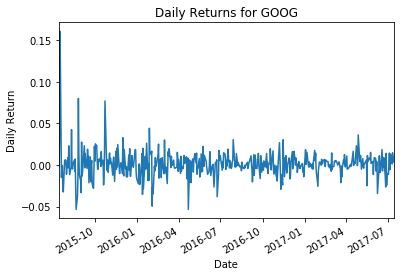

Max/Min Daily Returns for GOOG
Max: 0.160524309481
Min: -0.0531785891961





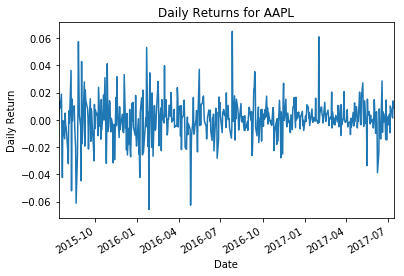

Max/Min Daily Returns for AAPL
Max: 0.0649632681279
Min: -0.0657065719713





In [8]:
daily_returns  = get_daily_returns(df_explore)
for symbol in tickers:
    plot_data(daily_returns[symbol], title='Daily Returns for ' + symbol, xlabel='Date', ylabel='Daily Return')

    print 'Max/Min Daily Returns for ' + symbol
    print 'Max:', daily_returns[symbol].max()
    print 'Min:', daily_returns[symbol].min()
    print '\n\n'

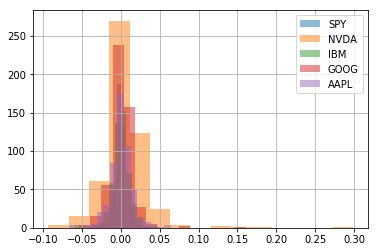

In [9]:
plot_hist_multi(daily_returns, bins=15)

## Momentum
---

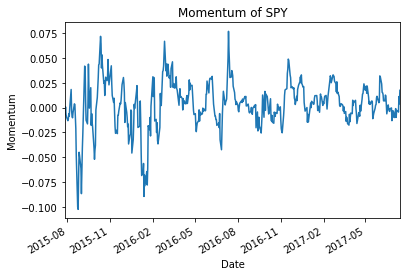

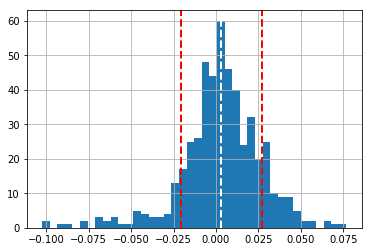

Max/Min Momentum for SPY
Max: 0.0769037602133
Min: -0.102554244525





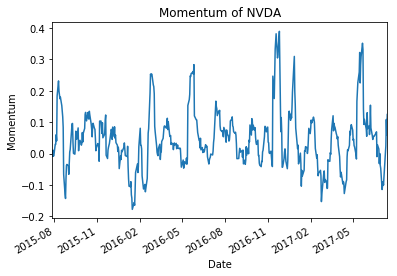

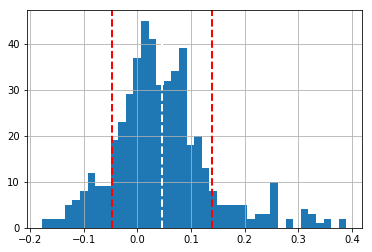

Max/Min Momentum for NVDA
Max: 0.389405462125
Min: -0.177487808783





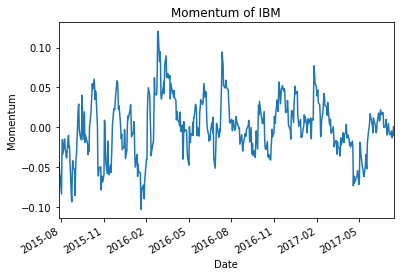

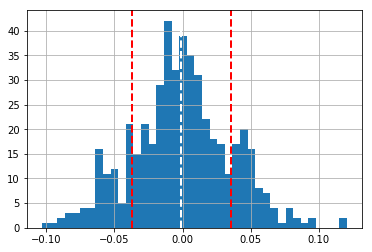

Max/Min Momentum for IBM
Max: 0.120322454312
Min: -0.102981261554





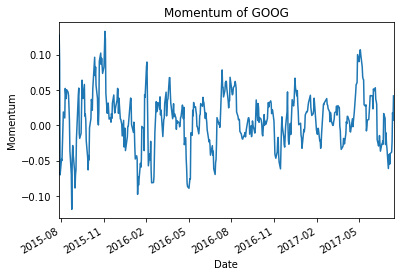

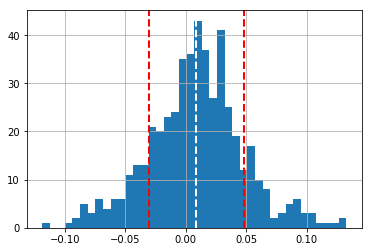

Max/Min Momentum for GOOG
Max: 0.133051153881
Min: -0.119131976672





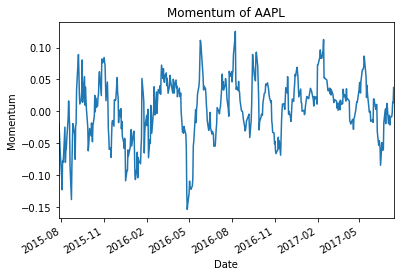

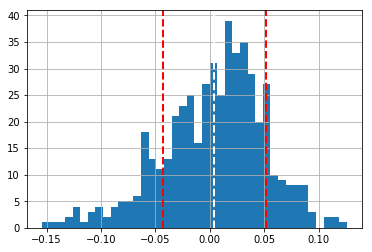

Max/Min Momentum for AAPL
Max: 0.125581879085
Min: -0.15405884307





In [10]:
for symbol in tickers:
    momentum = get_momentum(df_explore[symbol], window=metrics_window)
    plot_data(momentum, title='Momentum of ' + symbol, xlabel='Date', ylabel='Momentum')
    plot_hist_with_stats(momentum, bins=40)

    print 'Max/Min Momentum for ' + symbol
    print 'Max:', momentum.max()
    print 'Min:', momentum.min()
    print '\n\n'

## Simple Moving Average Ratio
---

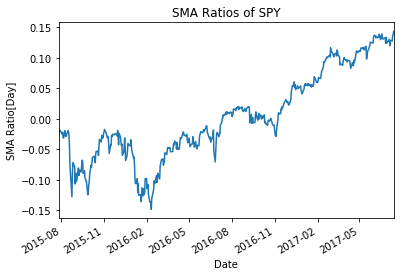

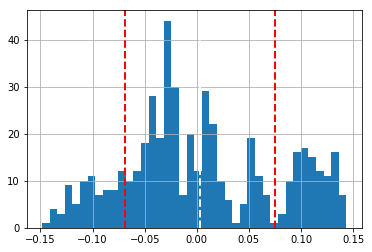

Max/Min SMA Ratio for SPY
Max:  0.143536239672
Min:  -0.148448282973


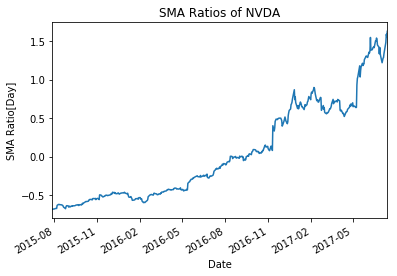

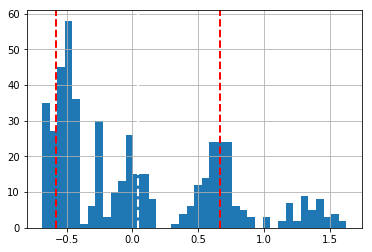

Max/Min SMA Ratio for NVDA
Max:  1.62571900665
Min:  -0.685932482913


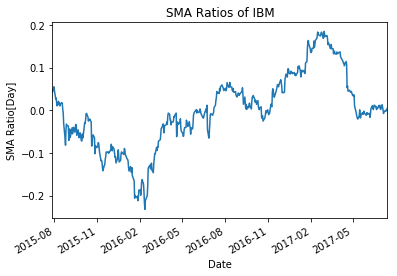

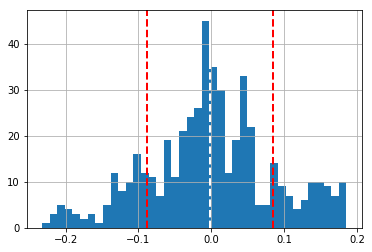

Max/Min SMA Ratio for IBM
Max:  0.185252953544
Min:  -0.232305245904


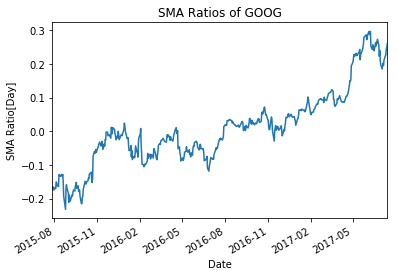

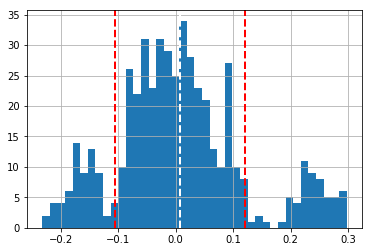

Max/Min SMA Ratio for GOOG
Max:  0.297455543363
Min:  -0.23227373094


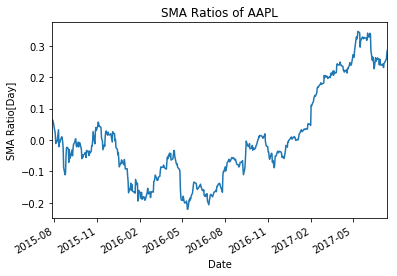

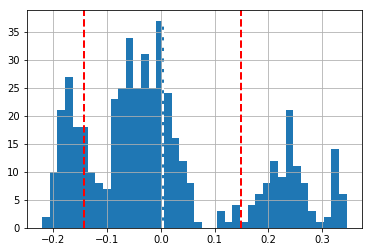

Max/Min SMA Ratio for AAPL
Max:  0.34595194749
Min:  -0.221055164134


In [11]:
for symbol in tickers:
    sma_ratios = get_sma_ratio(df_explore[symbol], window=metrics_window)

    plot_data(sma_ratios, title='SMA Ratios of ' + symbol, xlabel='Date', ylabel='SMA Ratio[Day]')
    plot_hist_with_stats(sma_ratios, bins=40)

    print 'Max/Min SMA Ratio for ' + symbol
    print 'Max: ', sma_ratios.max()
    print 'Min: ', sma_ratios.min()

## Bolinger Ratios
---

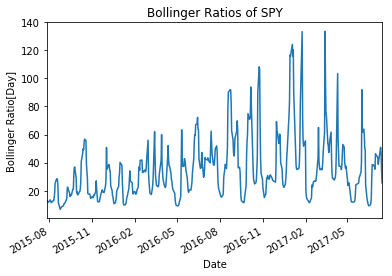

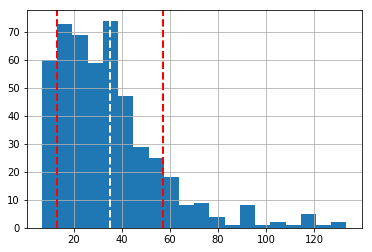

Max/Min BB Ratio for SPY
Max: 133.382631054
Min: 6.76325522189


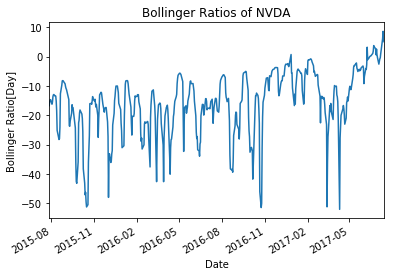

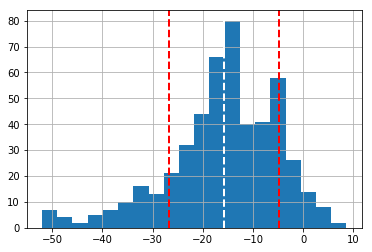

Max/Min BB Ratio for NVDA
Max: 8.59636968705
Min: -52.0133531768


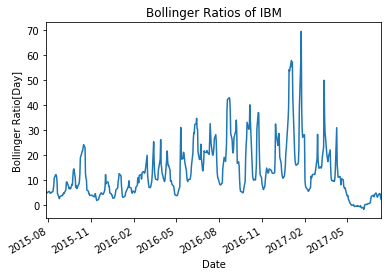

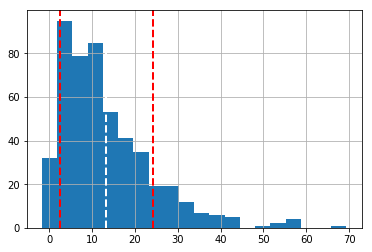

Max/Min BB Ratio for IBM
Max: 69.3821058397
Min: -1.67965049796


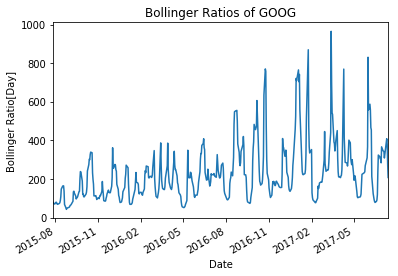

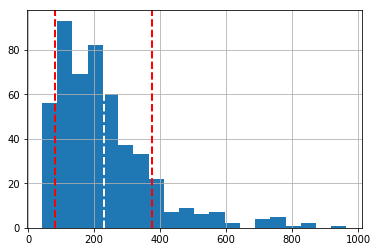

Max/Min BB Ratio for GOOG
Max: 964.763746296
Min: 42.2500959338


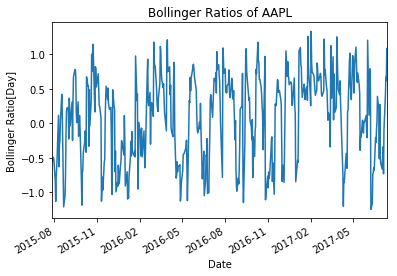

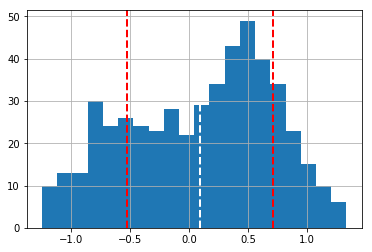

Max/Min BB Ratio for AAPL
Max: 1.33496258951
Min: -1.24447686579


In [12]:
for symbol in tickers:
    bb_ratios = get_bollinger_ratios(series=df_explore[symbol], sma=rolling_mean, r_std=rolling_std, window=metrics_window)

    plot_data(bb_ratios, title='Bollinger Ratios of ' + symbol, xlabel='Date', ylabel='Bollinger Ratio[Day]')
    plot_hist_with_stats(bb_ratios, bins=20, title=symbol)

    print 'Max/Min BB Ratio for ' + symbol
    print 'Max:', bb_ratios.max()
    print 'Min:', bb_ratios.min()

## Example Set Up of the Feature Set
---


In [20]:
# The final features to be used will be the Bollinger Bands Ratio,
# the momentum, and the Simple Moving Average Ratio. The three values
# are easlity converted into numerical values suitable for Machine Learning
# aglorithms

# This is an example set of features to be passed to the ML algos in the following sections

# recombine the features into a new Data Frame X and Y. 
# X will be a frame of all the featres for and Y will be the outcomes

# NVDA as the example
rolling_mean = get_rolling_mean(df_explore['SPY'], metrics_window)
rolling_std = get_rolling_std(df_explore['SPY'], metrics_window)

d = { 
    'BB_RATIOS' : get_bollinger_ratios(series=df_explore['SPY'], sma=rolling_mean, r_std=rolling_std, window=metrics_window), 
    'SMA_RATIOS' : get_sma_ratio(df_explore['SPY'], window=metrics_window), 
    'MOMENTUM' : get_momentum(df_explore['SPY'], window=metrics_window)
}
features_df = pd.DataFrame(d)

X_features = features_df[0 : -1].values
y_target = df_explore['SPY'][(metrics_window + 1) : ].values

X_faetures_7152017 = features_df.tail(1)

print 'Features Length', len(X_features)
print 'Target Length', len(y_target)
print features_df.head()


Features Length 495
Target Length 495
            BB_RATIOS  MOMENTUM  SMA_RATIOS
2015-07-28  -0.305356 -0.006408   -0.025181
2015-07-29   0.053972  0.000760   -0.018476
2015-07-30   0.108938 -0.006971   -0.018243
2015-07-31   0.082941 -0.009319   -0.019733
2015-08-03  -0.045573 -0.013171   -0.023039


/Users/mattbozelka/.pyenv/versions/anaconda2-4.4.0/envs/ml-capstone-env/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


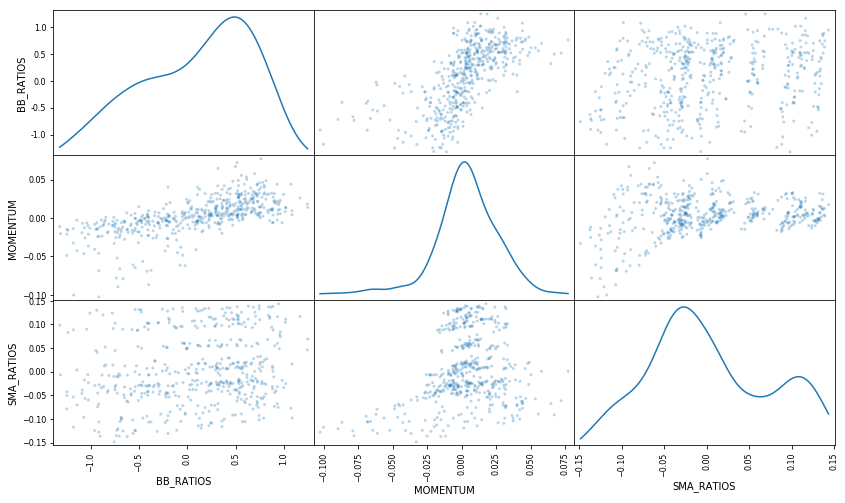

In [24]:
pd.scatter_matrix(features_df, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

## Machine Learning Algos
---
The final following sections will run each test stock through a few different machine learning algorithms to determine the best model to be used for our predictions. The chosen algos that are believed to be the best fit for the data type are KNN, a simple linear regression, and a Random Forrest.

## KNN
---

KNN Evaluation and scores for  SPY

Train scores [1.0, 1.0, 1.0]
Train Scores Mean 1.0, Train Scores STD 0.0

Test scores [0.82316702475559156, -1.2174454751979429, -5.4695900628584537]
Test Scores Mean -1.95462283777, Test Scores STD 2.62135725517

Predictions [ 226.25392135  223.64819328  225.55823248  224.79312837  226.12281596
  225.9735832   226.43136578  226.54049371  225.81384982  225.98462388
  225.89051164  226.03054659]

Actual [ 225.910004  226.740005  226.149994  227.600006  229.570007  229.330002
  228.970001  227.550003  227.529999  227.619995  227.770004  229.339996]


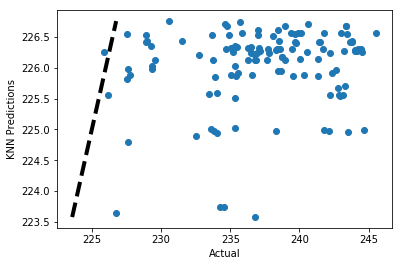




KNN Evaluation and scores for  NVDA

Train scores [1.0, 1.0, 1.0]
Train Scores Mean 1.0, Train Scores STD 0.0

Test scores [-0.520432398707948, -1.863380282096134, -0.49238335920927906]
Test Scores Mean -0.958732013338, Test Scores STD 0.639785409222

Predictions [ 103.0447412    98.02578497  102.78822739   98.96791568   96.71331608
   99.25947728  101.88215811  103.90600754   99.79825646   99.95471238
  105.94952871  106.02499425]

Actual [ 105.160004  104.010002  105.089996  107.330002  107.790001  109.650002
  111.769997  110.019997  109.18      113.949997  115.389999  114.379997]


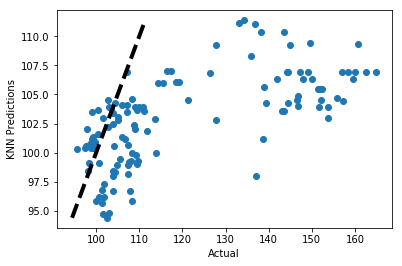




KNN Evaluation and scores for  IBM

Train scores [1.0, 1.0, 1.0]
Train Scores Mean 1.0, Train Scores STD 0.0

Test scores [0.73234908037787394, -0.31342073104348356, 0.60938230350409084]
Test Scores Mean 0.342770217613, Test Scores STD 0.466704851684

Predictions [ 166.72461338  165.57582057  168.03192946  168.0247495   167.76677257
  164.36985435  166.68423119  167.42558004  167.24556407  167.09925139
  167.1061623   167.11760085]

Actual [ 166.809998  170.550003  171.029999  175.899994  178.289993  178.660004
  177.300003  175.800003  174.520004  174.289993  174.580002  175.820007]


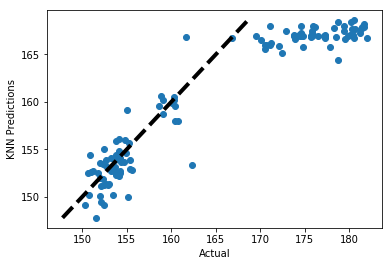




KNN Evaluation and scores for  GOOG

Train scores [1.0, 1.0, 1.0]
Train Scores Mean 1.0, Train Scores STD 0.0

Test scores [0.31467536518252492, -3.0835618444051276, -1.8741606331860408]
Test Scores Mean -1.5476823708, Test Scores STD 1.40640086154

Predictions [ 799.76001584  787.07999835  786.83072133  795.34169446  803.78667608
  803.67488973  805.07585016  804.46613881  780.87597665  778.42181447
  777.9493481   782.51665344]

Actual [ 802.174988  805.02002   819.309998  823.869995  835.669983  832.150024
  823.309998  802.320007  796.789978  795.695007  798.530029  801.48999 ]


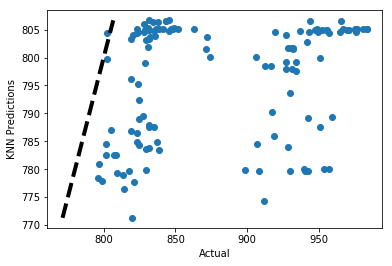




KNN Evaluation and scores for  AAPL

Train scores [1.0, 1.0, 1.0]
Train Scores Mean 1.0, Train Scores STD 0.0

Test scores [0.67069322733905001, 0.81560921574065526, -6.0493214394861399]
Test Scores Mean -1.52100633214, Test Scores STD 3.20254882289

Predictions [ 119.05224974  119.45291805  119.00114849  118.90742324  118.58146803
  117.95747931  118.6416734   119.25394771  119.49890234  119.2140557
  119.88608898  121.16494943]

Actual [ 119.779999  120.        120.080002  119.970001  121.879997  121.940002
  121.949997  121.629997  121.349998  128.75      128.529999  129.080002]


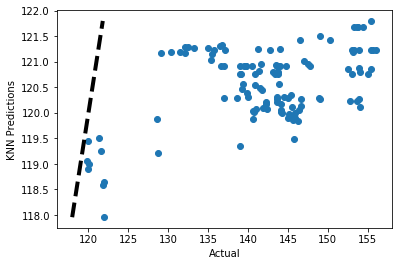

In [14]:
for symbol in tickers:
    rolling_mean = get_rolling_mean(df_explore[symbol], metrics_window)
    rolling_std = get_rolling_std(df_explore[symbol], metrics_window)

    d = { 
        'BB_RATIOS' : get_bollinger_ratios(series=df_explore[symbol], sma=rolling_mean, r_std=rolling_std, window=metrics_window), 
        'SMA_RATIOS' : get_sma_ratio(df_explore[symbol], window=metrics_window), 
        'MOMENTUM' : get_momentum(df_explore[symbol], window=metrics_window)
    }
    features_df = pd.DataFrame(d)

    X_features = features_df[0 : -1].values
    y_target = df_explore[symbol][(metrics_window + 1) : ].values


    pipe_knn = Pipeline([
            ('scl', StandardScaler()),
            ('clf', KNeighborsRegressor(n_neighbors=5, weights='distance'))
        ])

    tscv = TimeSeriesSplit(n_splits=3)
    train_scores = []
    test_scores = []

    final_predics = []
    actual_vals = []

    for train_index, test_index in tscv.split(X_features):
        pipe_knn.fit(X_features[train_index], y_target[train_index])

        train_score = pipe_knn.score(X_features[train_index], y_target[train_index])
        test_score = pipe_knn.score(X_features[test_index], y_target[test_index])

        train_scores.append(train_score)
        test_scores.append(test_score)

        final_predic = pipe_knn.predict(X_features[test_index])
        actual_vals = y_target[test_index]
    
    print 'KNN Evaluation and scores for ', symbol
    print '\nTrain scores', train_scores
    print 'Train Scores Mean {}, Train Scores STD {}'.format(np.asarray(train_scores).mean(), np.asarray(train_scores).std())

    print '\nTest scores', test_scores
    print 'Test Scores Mean {}, Test Scores STD {}'.format(np.asarray(test_scores).mean(), np.asarray(test_scores).std())

    print '\nPredictions', final_predic[0: 12]

    print '\nActual', actual_vals[0: 12]

    plot_predictions(actual_vals, final_predic, y_label='KNN Predictions')
    print '\n\n'

## Linear Regression 
---

Linear Regression Evaluation and scores for  SPY

Train scores [0.88979791850868362, 0.92024256748210531, 0.96387612900408115]
Train Scores Mean 0.924638871665, Train Scores STD 0.0304016549484

Test scores [0.93958188537451481, 0.91638686145572701, 0.94196654021776494]
Test Scores Mean 0.932645095683, Test Scores STD 0.0115374543643

Predictions [ 226.58824881  225.77857694  226.59870442  226.02834155  227.44971854
  229.37080098  229.14159813  228.77707752  227.39614487  227.36200677
  227.45815312  227.58919429]

Actual [ 225.910004  226.740005  226.149994  227.600006  229.570007  229.330002
  228.970001  227.550003  227.529999  227.619995  227.770004  229.339996]

Adjusted value first day after Selected Dates
[ 245.17678777]


/Users/mattbozelka/.pyenv/versions/anaconda2-4.4.0/envs/ml-capstone-env/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


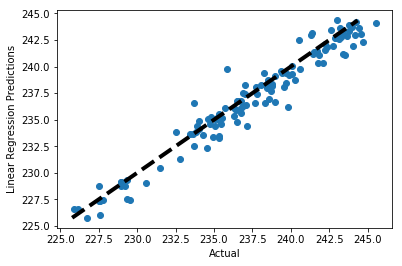




Linear Regression Evaluation and scores for  NVDA

Train scores [0.97612664967981166, 0.99217583966585587, 0.99519416542680761]
Train Scores Mean 0.987832218257, Train Scores STD 0.00836830625614

Test scores [0.98486958799777879, 0.97661017384105897, 0.97194658312438176]
Test Scores Mean 0.977808781654, Test Scores STD 0.00534343892121

Predictions [ 103.46985738  105.61210732  104.4990622   105.55007289  107.72155195
  108.17624879  110.01185235  112.1165844   110.42505462  109.60029508
  114.29256218  115.7510993 ]

Actual [ 105.160004  104.010002  105.089996  107.330002  107.790001  109.650002
  111.769997  110.019997  109.18      113.949997  115.389999  114.379997]

Adjusted value first day after Selected Dates
[ 165.4873633]


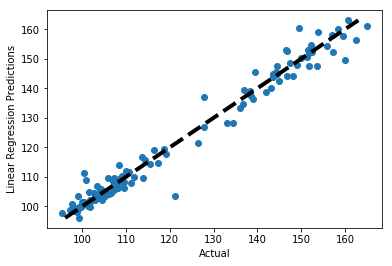




Linear Regression Evaluation and scores for  IBM

Train scores [0.94496649661994214, 0.95356864491751714, 0.9724263166403978]
Train Scores Mean 0.956987152726, Train Scores STD 0.0114680738172

Test scores [0.9526118936443625, 0.91644252967628825, 0.98359800672947462]
Test Scores Mean 0.95088414335, Test Scores STD 0.0274433157055

Predictions [ 166.6791059   166.63390005  170.14031948  170.61861169  175.50290927
  177.98255998  178.35637984  177.0369731   175.58449259  174.32467523
  174.13638946  174.44606738]

Actual [ 166.809998  170.550003  171.029999  175.899994  178.289993  178.660004
  177.300003  175.800003  174.520004  174.289993  174.580002  175.820007]

Adjusted value first day after Selected Dates
[ 154.12777911]


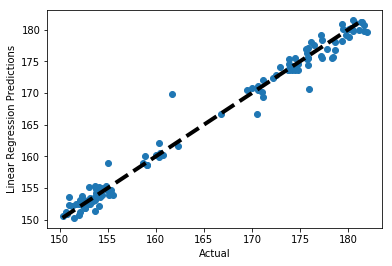




Linear Regression Evaluation and scores for  GOOG

Train scores [0.95317547659144441, 0.94134437546405403, 0.96422576220007516]
Train Scores Mean 0.952915204752, Train Scores STD 0.00934309980016

Test scores [0.79460384299429065, 0.76089188970371868, 0.97455135182776487]
Test Scores Mean 0.843349028175, Test Scores STD 0.0937893428471

Predictions [ 804.8449382   801.05137424  803.97450571  818.22602982  822.56517124
  833.82409185  830.47026688  821.89261561  801.69157451  796.2904452
  795.28520356  797.92317337]

Actual [ 802.174988  805.02002   819.309998  823.869995  835.669983  832.150024
  823.309998  802.320007  796.789978  795.695007  798.530029  801.48999 ]

Adjusted value first day after Selected Dates
[ 951.97834102]


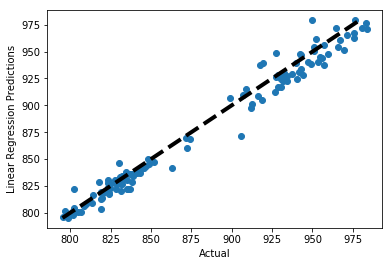




Linear Regression Evaluation and scores for  AAPL

Train scores [0.89108800159725798, 0.95567008124073416, 0.95729573617549124]
Train Scores Mean 0.934684606338, Train Scores STD 0.0308345979615

Test scores [0.93280708206084384, 0.91739145276137368, 0.95458081316125232]
Test Scores Mean 0.934926449328, Test Scores STD 0.0152562756475

Predictions [ 119.7384258   119.51754414  119.74411435  119.82360696  119.68504534
  121.66890583  121.67941878  121.6682704   121.32610893  121.02084773
  128.40034624  128.13283416]

Actual [ 119.779999  120.        120.080002  119.970001  121.879997  121.940002
  121.949997  121.629997  121.349998  128.75      128.529999  129.080002]

Adjusted value first day after Selected Dates
[ 148.08990295]


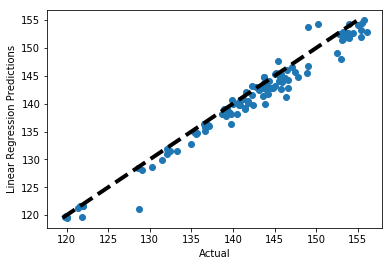

In [15]:
for symbol in tickers:
    rolling_mean = get_rolling_mean(df_explore[symbol], metrics_window)
    rolling_std = get_rolling_std(df_explore[symbol], metrics_window)

    d = { 
        'BB_RATIOS' : get_bollinger_ratios(series=df_explore[symbol], sma=rolling_mean, r_std=rolling_std, window=metrics_window), 
        'SMA_RATIOS' : get_sma_ratio(df_explore[symbol], window=metrics_window), 
        'MOMENTUM' : get_momentum(df_explore[symbol], window=metrics_window)
    }
    features_df = pd.DataFrame(d)

    X_features = features_df[0 : -1].values
    y_target = df_explore[symbol][(metrics_window + 1) : ].values
    
    pipe_lr = Pipeline([
            ('scl', StandardScaler()),
            ('clf', LinearRegression())
        ])

    tscv = TimeSeriesSplit(n_splits=3)
    train_scores = []
    test_scores = []

    final_predics = []
    actual_vals = []

    for train_index, test_index in tscv.split(X_features):
        pipe_lr.fit(X_features[train_index], y_target[train_index])

        train_score = pipe_lr.score(X_features[train_index], y_target[train_index])
        test_score = pipe_lr.score(X_features[test_index], y_target[test_index])

        train_scores.append(train_score)
        test_scores.append(test_score)

        final_predic = pipe_lr.predict(X_features[test_index])
        actual_vals = y_target[test_index]

    print 'Linear Regression Evaluation and scores for ', symbol
    print '\nTrain scores', train_scores
    print 'Train Scores Mean {}, Train Scores STD {}'.format(np.asarray(train_scores).mean(), np.asarray(train_scores).std())

    print '\nTest scores', test_scores
    print 'Test Scores Mean {}, Test Scores STD {}'.format(np.asarray(test_scores).mean(), np.asarray(test_scores).std())

    print '\nPredictions', final_predic[0: 12]

    print '\nActual', actual_vals[0: 12]

    X_faetures_7152017 = pipe_lr.predict(features_df.tail(1))
    print '\nAdjusted value first day after Selected Dates\n', X_faetures_7152017

    plot_predictions(actual_vals, final_predic, y_label='Linear Regression Predictions')
    print '\n\n'

## Random Forests

Random Forests Evaluation and scores for  SPY

Train scores [0.97323835048520013, 0.979533910268236, 0.98944389151382517]
Train Scores Mean 0.980738717422, Train Scores STD 0.00667051023619

Test scores [0.85380402071540584, -0.035299241483000676, -5.4039418015905429]
Test Scores Mean -1.52847900745, Test Scores STD 2.76430040025

Predictions [ 225.9559998  225.8800018  225.0619966  225.8800018  226.4800022
  226.4899998  226.4180056  226.4480044  225.3239992  225.9440034
  225.9320008  226.152002 ]

Actual [ 225.910004  226.740005  226.149994  227.600006  229.570007  229.330002
  228.970001  227.550003  227.529999  227.619995  227.770004  229.339996]


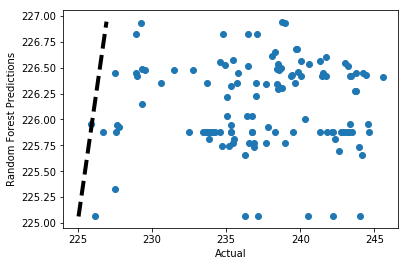




Random Forests Evaluation and scores for  NVDA

Train scores [0.99425789909751483, 0.99761854837810648, 0.99855380705450625]
Train Scores Mean 0.996810084843, Train Scores STD 0.00184461671881

Test scores [-0.47044464768411731, -1.7117248893147288, -0.41147045472258686]
Test Scores Mean -0.864546663907, Test Scores STD 0.599529091906

Predictions [ 103.836      103.9540008  102.5339996  103.9540008  106.0539994
  106.0539994  106.0539994  106.8720002  106.3679994  106.9259994
  106.8720002  106.7399994]

Actual [ 105.160004  104.010002  105.089996  107.330002  107.790001  109.650002
  111.769997  110.019997  109.18      113.949997  115.389999  114.379997]


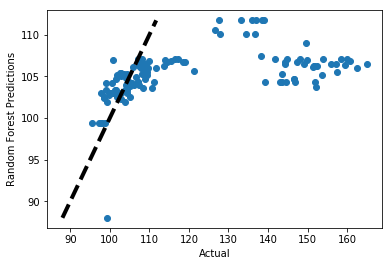




Random Forests Evaluation and scores for  IBM

Train scores [0.9824497976248795, 0.98361965428217513, 0.99273531576323371]
Train Scores Mean 0.98626825589, Train Scores STD 0.00459777400501

Test scores [0.92652400153971126, 0.47095333011867246, 0.64982982047754878]
Test Scores Mean 0.682435717379, Test Scores STD 0.187409564945

Predictions [ 166.8859984  166.694003   168.0319948  168.0139956  168.0339996
  168.0339996  167.4299988  167.4299988  167.2819978  167.175998
  167.3059998  167.3059998]

Actual [ 166.809998  170.550003  171.029999  175.899994  178.289993  178.660004
  177.300003  175.800003  174.520004  174.289993  174.580002  175.820007]


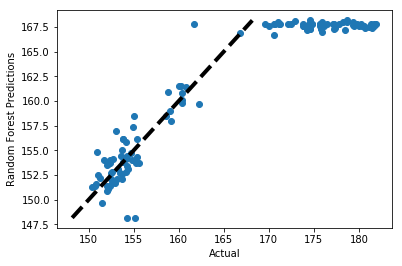




Random Forests Evaluation and scores for  GOOG

Train scores [0.98872091283599373, 0.98725280756511113, 0.99020474515490797]
Train Scores Mean 0.988726155185, Train Scores STD 0.0012051291757

Test scores [0.57722682474960751, -2.5420488820984937, -1.5083470814951032]
Test Scores Mean -1.15772304628, Test Scores STD 1.29734938609

Predictions [ 806.1180054  798.5819946  805.8720092  805.88999    805.88999
  806.3559814  806.513989   804.0520018  796.521997   789.123987
  789.123987   789.071985 ]

Actual [ 802.174988  805.02002   819.309998  823.869995  835.669983  832.150024
  823.309998  802.320007  796.789978  795.695007  798.530029  801.48999 ]


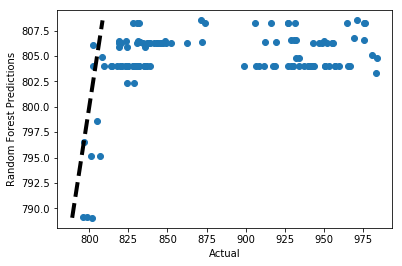




Random Forests Evaluation and scores for  AAPL

Train scores [0.97202391207773475, 0.98353270666487547, 0.98655774856062595]
Train Scores Mean 0.980704789101, Train Scores STD 0.00626130652173

Test scores [0.59516248933127536, 0.84736431813996349, -5.1405542107959263]
Test Scores Mean -1.23267580111, Test Scores STD 2.76520483741

Predictions [ 119.7999986  119.7999986  119.7999986  119.4479996  119.1759996
  121.4939988  121.4939988  121.4939988  121.3339984  120.8099992
  122.3779984  122.3779984]

Actual [ 119.779999  120.        120.080002  119.970001  121.879997  121.940002
  121.949997  121.629997  121.349998  128.75      128.529999  129.080002]


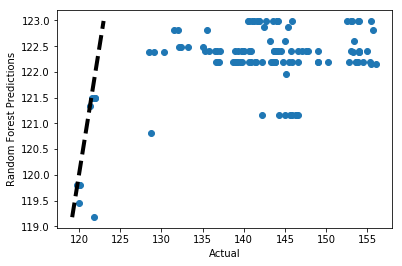

In [16]:
for symbol in tickers:
    rolling_mean = get_rolling_mean(df_explore[symbol], metrics_window)
    rolling_std = get_rolling_std(df_explore[symbol], metrics_window)

    d = { 
        'BB_RATIOS' : get_bollinger_ratios(series=df_explore[symbol], sma=rolling_mean, r_std=rolling_std, window=metrics_window), 
        'SMA_RATIOS' : get_sma_ratio(df_explore[symbol], window=metrics_window), 
        'MOMENTUM' : get_momentum(df_explore[symbol], window=metrics_window)
    }
    features_df = pd.DataFrame(d)

    X_features = features_df[0 : -1].values
    y_target = df_explore[symbol][(metrics_window + 1) : ].values

    clf_rf = RandomForestRegressor(n_estimators=5)
    tscv = TimeSeriesSplit(n_splits=3)

    train_scores = []
    test_scores = []

    final_predics = []
    actual_vals = []

    for train_index, test_index in tscv.split(X_features):
        clf_rf.fit(X_features[train_index], y_target[train_index])

        train_score = clf_rf.score(X_features[train_index], y_target[train_index])
        test_score = clf_rf.score(X_features[test_index], y_target[test_index])

        train_scores.append(train_score)
        test_scores.append(test_score)

        final_predic = clf_rf.predict(X_features[test_index])
        actual_vals = y_target[test_index]
    
    print 'Random Forests Evaluation and scores for ', symbol
    print '\nTrain scores', train_scores
    print 'Train Scores Mean {}, Train Scores STD {}'.format(np.asarray(train_scores).mean(), np.asarray(train_scores).std())

    print '\nTest scores', test_scores
    print 'Test Scores Mean {}, Test Scores STD {}'.format(np.asarray(test_scores).mean(), np.asarray(test_scores).std())

    print '\nPredictions', final_predic[0: 12]

    print '\nActual', actual_vals[0: 12]

    plot_predictions(actual_vals, final_predic, y_label='Random Forest Predictions')
    print '\n\n'

## Evaluation
---
After running my predictions through 3 different classifers the only one worth looking forward on is the Linear Regresion classifier.

The scores are more than acceptable, and based on the score on the training and testing set it does not seem to be overfitting.

Running through a few different stocks indicates that the more volitile the stock the worse the predictions are.

My goal now is to write some classes and functions that will be usefull in the final presentation. 